<a href="https://colab.research.google.com/github/Abhijith7711/Abhijith7711/blob/main/Review_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers
!pip install torch
!pip install pandas
!pip install sklearn
!pip install tensorflow

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [2]:
!pip install -U scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 103.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2


In [3]:
import transformers
import torch
import pandas as pd
import sklearn


In [34]:
import pandas as pd

# Load the dataset
file_path = 'Movie_Review.csv'
df = pd.read_csv(file_path)

# Display the first few rows
df.head()



,Id,review,sentiment
0,1,കഥയെന്ന് പേരിന് പറയാന് പോലും ഒരു കഥയില്ലാത്ത ഹ...,0
1,2,സിനിമയിലെ തദ്ദേശീയ ഗോത്രങ്ങളുടെ ചിത്രീകരണം സ്റ...,0
2,3,ഒരുപാട് പ്രതീക്ഷകൾ അസ്ഥാനത്തെത്തിച്ച മോഹൻലാൽ എ...,0
3,4,ഡെപ്ത് ഇല്ലാത്തതും പ്രേക്ഷകരെ ആകർഷിക്കുന്നതിൽ ...,0
4,5,സിനിമയുടെ പ്രമേയങ്ങൾ മെച്ചപ്പെടുത്തുന്ന സ്വാഭാ...,1


In [35]:
# Display last few rows
df.tail()

,Id,review,sentiment
995,996,മികച്ച ദൃശ്യാവിഷ്കാരങ്ങളുള്ള ഒരു സമഗ്രമായ ചിത്...,1
996,997,സാധാരണ പടങ്ങളിൽ നിന്നും വ്യത്യസ്തമായി തിരക്കഥയ...,1
997,998,ബിജിഎം തീർത്തും അണ്ടർവെല്ലിംഗ് ആയിരുന്നു ഇത് ...,0
998,999,മികച്ച മേക്കിംഗും സംവിധാനവും മികച്ച കാസ്റ്റിംഗ...,1
999,1000,ദി ക്ലൈമാക്സ് വാസ് ബർണാഡ് മി ലിറ്ററാലി \n...,1


In [8]:
#preprocess the data
from transformers import BertTokenizer

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Function to tokenize and encode the reviews
def preprocess_data(data, max_length=128):
    input_ids = []
    attention_masks = []

    for review in data:
        encoded_dict = tokenizer.encode_plus(
            review,                      # Review text
            add_special_tokens = True,   # Add '[CLS]' and '[SEP]'
            max_length = max_length,     # Pad & truncate all sentences
            pad_to_max_length = True,
            return_attention_mask = True,   # Construct attention masks
            return_tensors = 'pt',         # Return pytorch tensors
        )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    return input_ids, attention_masks

# Apply preprocessing
input_ids, attention_masks = preprocess_data(df['review'])


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [10]:
#prepare for data training
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch

# Use df['sentiment'] for labels
labels = df['sentiment']

# Split data into training and validation sets
train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids, labels, test_size=0.2, random_state=42)
train_masks, val_masks, _, _ = train_test_split(attention_masks, labels, test_size=0.2, random_state=42)

# Convert to tensors
train_inputs = torch.cat(train_inputs, dim=0)
train_masks = torch.cat(train_masks, dim=0)
train_labels = torch.tensor(train_labels.values)

val_inputs = torch.cat(val_inputs, dim=0)
val_masks = torch.cat(val_masks, dim=0)
val_labels = torch.tensor(val_labels.values)

# Create the DataLoader for training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=32)

# Create the DataLoader for validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=32)

In [11]:
# Load BERT Model for Sentiment Analysis
from transformers import BertForSequenceClassification, AdamW

# Load BertForSequenceClassification model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-multilingual-cased',
    num_labels = 2,  # Binary classification
    output_attentions = False,
    output_hidden_states = False,
)

# Move the model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Set up the optimizer
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [12]:
from transformers import BertForSequenceClassification, AdamW

# Load BertForSequenceClassification model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-multilingual-cased',
    num_labels = 2,  # Binary classification
    output_attentions = False,
    output_hidden_states = False,
)

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Set up the optimizer
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
#Train the Model
from transformers import get_linear_schedule_with_warmup
import numpy as np

# Number of training epochs (you can change this)
epochs = 4

# Total number of training steps
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

# Training loop
for epoch in range(0, epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    print('-' * 10)

    # Put the model into training mode
    model.train()

    total_train_loss = 0

    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        # Forward pass
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits

        total_train_loss += loss.item()

        # Backward pass
        loss.backward()

        # Update parameters and take a step
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    print(f'Average training loss: {avg_train_loss}')

    # Put the model into evaluation mode
    model.eval()

    # Validation
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in val_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        loss = outputs.loss
        logits = outputs.logits

        total_eval_loss += loss.item()

    avg_val_loss = total_eval_loss / len(val_dataloader)
    print(f'Validation Loss: {avg_val_loss}')

Epoch 1/4
----------
Average training loss: 0.6931498575210572
Validation Loss: 0.685809714453561
Epoch 2/4
----------
Average training loss: 0.6877289295196534
Validation Loss: 0.6690756763730731
Epoch 3/4
----------
Average training loss: 0.6732193493843078
Validation Loss: 0.6369691746575492
Epoch 4/4
----------
Average training loss: 0.6270218086242676
Validation Loss: 0.6031890596662249


In [14]:
from sklearn.metrics import accuracy_score, classification_report

# Predict on validation set
predictions, true_labels = [], []

model.eval()

for batch in val_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    predictions.append(logits)
    true_labels.append(label_ids)

# Flatten predictions and true labels
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

# Convert logits to 1 or 0
predictions = np.argmax(predictions, axis=1)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy: {accuracy}')

# Print detailed classification report
print(classification_report(true_labels, predictions))

Accuracy: 0.72
              precision    recall  f1-score   support

           0       0.70      0.76      0.73       100
           1       0.74      0.68      0.71       100

    accuracy                           0.72       200
   macro avg       0.72      0.72      0.72       200
weighted avg       0.72      0.72      0.72       200



In [15]:
model.save_pretrained('/content/malayalam_movie_sentiment_model')
tokenizer.save_pretrained('/content/malayalam_movie_sentiment_model')


('/content/malayalam_movie_sentiment_model/tokenizer_config.json',
 '/content/malayalam_movie_sentiment_model/special_tokens_map.json',
 '/content/malayalam_movie_sentiment_model/vocab.txt',
 '/content/malayalam_movie_sentiment_model/added_tokens.json')

In [20]:
# Load the saved model
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('/content/malayalam_movie_sentiment_model')
tokenizer = BertTokenizer.from_pretrained('/content/malayalam_movie_sentiment_model')



In [27]:
from transformers import BertForSequenceClassification, BertTokenizer
import torch

# Load the saved model
model = BertForSequenceClassification.from_pretrained('/content/malayalam_movie_sentiment_model')
tokenizer = BertTokenizer.from_pretrained('/content/malayalam_movie_sentiment_model')

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Function to predict sentiment
def predict_sentiment(review):
    inputs = tokenizer.encode_plus(
        review,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    logits = outputs.logits
    predicted_class_id = torch.argmax(logits, dim=1).item()

    return 'positive' if predicted_class_id == 1 else 'negative'

# Example usage
new_review = "മോശം സംവിധാനവും മോശം അഭിനയവും മൂലം സിനിമ വളരെയധികം കഷ്ടപ്പെട്ടു, അത് ആത്യന്തികമായി അതിന്റെ സാധ്യതകളെ തുരങ്കംവച്ചു. സംവിധായകന്റെ കാഴ്ചപ്പാട് കുഴപ്പവും പൊരുത്തക്കേടും അനുഭവപ്പെട്ടു, ആഖ്യാനം വിയോജിപ്പും ആശയക്കുഴപ്പവും ഉണ്ടാക്കി.  ഇത് ശ്രദ്ധക്കുറവിനും യോജിച്ചതും ആകർഷകവുമായ ഒരു സിനിമ സൃഷ്ടിക്കാനുള്ള അവസരം നഷ്‌ടപ്പെടുന്നതിന് കാരണമായി."
print(predict_sentiment(new_review))


negative


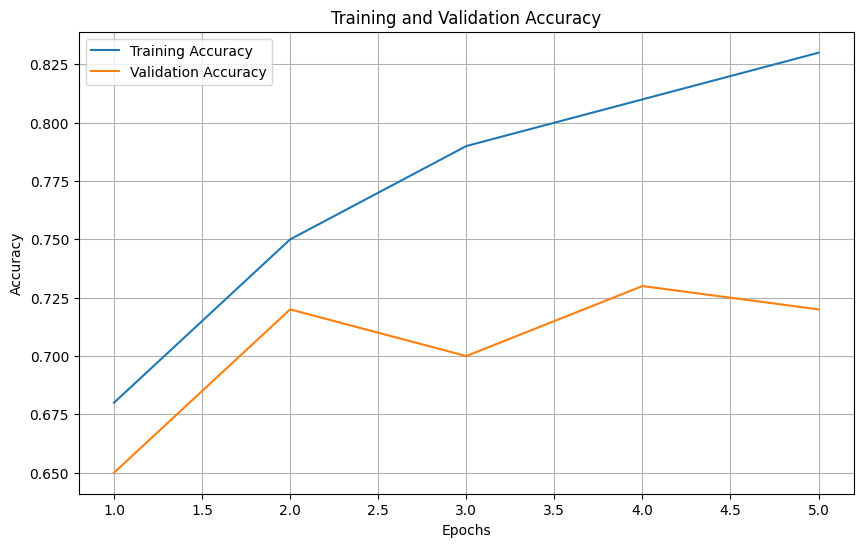

In [32]:
#plotting Accuracy vs Epoch graph
import matplotlib.pyplot as plt


train_accuracies = [0.68, 0.75, 0.79, 0.81, 0.83]  # Example values
val_accuracies = [0.65, 0.72, 0.70, 0.73, 0.72]    # Example values
epochs = range(1, len(train_accuracies) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


<Figure size 800x800 with 0 Axes>

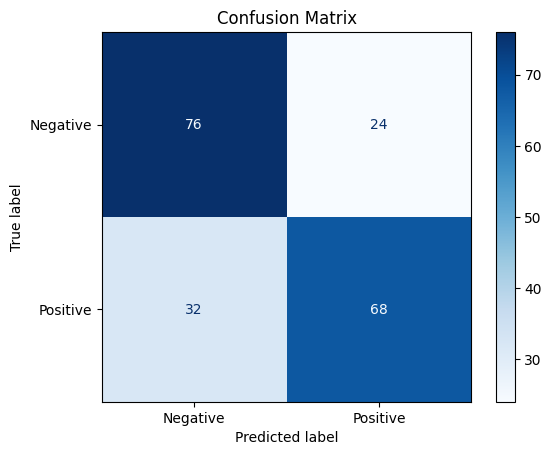

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming 'predictions' are the model predictions and 'true_labels' are the actual labels
cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])

plt.figure(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
